# Open-Source Implementation of IEEE P2427 Defect Coverage Standard

This Jupyter notebook details a prototype implementation of the [IEEE P2427 Draft Standard for Analog Defect Modeling and Coverage](https://standards.ieee.org/ieee/2427/7233/) using open source tools and the open source [Skywater 130A PDK](https://github.com/google/skywater-pdk).

It involves the following process:

1. A sample circuit is created and netlisted.
1.   Devices and nodes are in the netlist are parsed using a script.
2.   Defects are added into the netlist. These are modelled as large parameter changes, shorts or opens.
3.   The netlist is simulated and performance parameters are measured. If the performance parameters fall outside of the expected range, they are classified as failures.
4. Defect coverage is determined based in the percentage of defects detected by the tests and results are presented.

```
Submission to IEEE SSCS Open-Source Ecosystem “Code-a-Chip” Travel Grant Awards at ISSCC'25
SPDX-License-Identifier: GPL-3.0-only
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Timothy Jabez Newman (lead) <br /> Email ID: contact@timothynewman.co.uk|Independent|No|No|
|Feng Shen Foo <br /> Email ID: limited_fion@live.com|Independent|No|No|
|Ashcharya Kela <br /> Email ID: |Independent|No|No|
|Weizheng Wang <br /> Email ID: weizheng.w2020@gmail.com |Independent|No|No|

## Setting up of Open Source Tools

NGspice and Skywater 130A PDK are installed using micromamba.

This is largely based on the example at https://github.com/sscs-ose/sscs-ose-code-a-chip.github.io/blob/main/FAQ.md

In [16]:
# Import modules
import os
import pathlib
import sys
import re
import pandas as pd

In [17]:
!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        xschem \
                        #magic \
                        #netgen \
                        #openroad \
                        #yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice
%env PDK=sky130A

Streaming output truncated to the last 5000 lines.
Extracting   (1)  |  [+] 4m:37.4s
Extracting   (1)  |  [+] 4m:37.5s
Extracting   (1)  |  [+] 4m:37.6s
Extracting   (1)  |  [+] 4m:37.7s
Extracting   (1)  |  [+] 4m:37.8s
Extracting   (1)  |  [+] 4m:37.9s
Extracting   (1)  |  [+] 4m:38.0s
Extracting   (1)  |  [+] 4m:38.1s
Extracting   (1)  |  [+] 4m:38.2s
Extracting   (1)  |  [+] 4m:38.3s
Extracting   (1)  |  [+] 4m:38.4s
Extracting   (1)  |  [+] 4m:38.5s
Extracting   (1)  |  [+] 4m:38.6s
Extracting   (1)  |  [+] 4m:38.7s
Extracting   (1)  |  [+] 4m:38.8s
Extracting   (1)  |  [+] 4m:38.9s
Extracting   (1)  |  [+] 4m:39.0s
Extracting   (1)  |  [+] 4m:39.1s
Extracting   (1)  |  [+] 4m:39.2s
Extracting   (1)  |  [+] 4m:39.3s
Extracting   (1)  |  [+] 4m:39.4s
Extracting   (1)  |  [+] 4m:39.5s
Extracting   (1)  |  [+] 4m:39.6s
Extracting   (1)  |  [+] 4m:39.7s
Extracting   (1)  |  [+] 4m:39.8s
Extracting   (1)  |  [+] 4m:39.9s
Extracting   (1)  |  [+] 4m:40.0s
Extracting   (1)  |  [+] 4m:40.

To implement parameter defects, a modified version of the pdk transistor was created. This modified transistor was created using the ff and ss corner transistors and increasing the ``corner_factor`` from 1.0 to 1.5 to represent a transistor that operates outside of the acceptable performance parameters.

In [18]:
# Download modified Lib.tech folder from github
modified_libs_tech_folders_url = f"https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Modified_PDK/modified_libs_tech_folders.tar.gz"
!wget {modified_libs_tech_folders_url} -O modified_libs_tech_folders.tar.gz
!tar -xzvf modified_libs_tech_folders.tar.gz
!rm -rf /content/conda-env/share/pdk/sky130A/libs.tech/combined/
!rm -rf /content/conda-env/share/pdk/sky130A/libs.tech/xschem/
!cp combined/ /content/conda-env/share/pdk/sky130A/libs.tech/combined/ -r
!cp xschem/ /content/conda-env/share/pdk/sky130A/libs.tech/xschem/ -r


--2024-12-05 01:58:24--  https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Modified_PDK/modified_libs_tech_folders.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Modified_PDK/modified_libs_tech_folders.tar.gz [following]
--2024-12-05 01:58:24--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Modified_PDK/modified_libs_tech_folders.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2095045 (2.0M) [application/octet-stream]
Saving to: ‘modified_libs_tech

## Example SPICE Netlist

In this demonstration, a testbench is created to test a 5 transistor OpAmp.

Schematic capture was done in XSchem and a netlist was generated. Transient and AC simulations and performance parameters were included in the NGspice directive. The performance parameters are as follows:

* **slew_rate**: Slew rate of the OpAmp as measured by the output voltage rise from 10% to 90% of the maximum power supply voltage.
* **power_average**: Average power consumption over time.
* **aol_dc_db**: Open loop small signal gain measured at 10Hz.
* **bw3db**: Bandwidth of OpAmp small signal gain measured at 3dB below aol_dc_db.
* **ugbw**: Unity gain bandwidth is the frequency at 0dB small signal gain.
* **gain_margin**: Gain margin is defined as the magnitude of small signal gain at -180deg gain phase.
* **phase_margin**: Phase margin is defined as the difference between small signal gain phase and -180 phase at 0dB small signal gain magnitude.

**Test bench for testing the opamp circuit:**

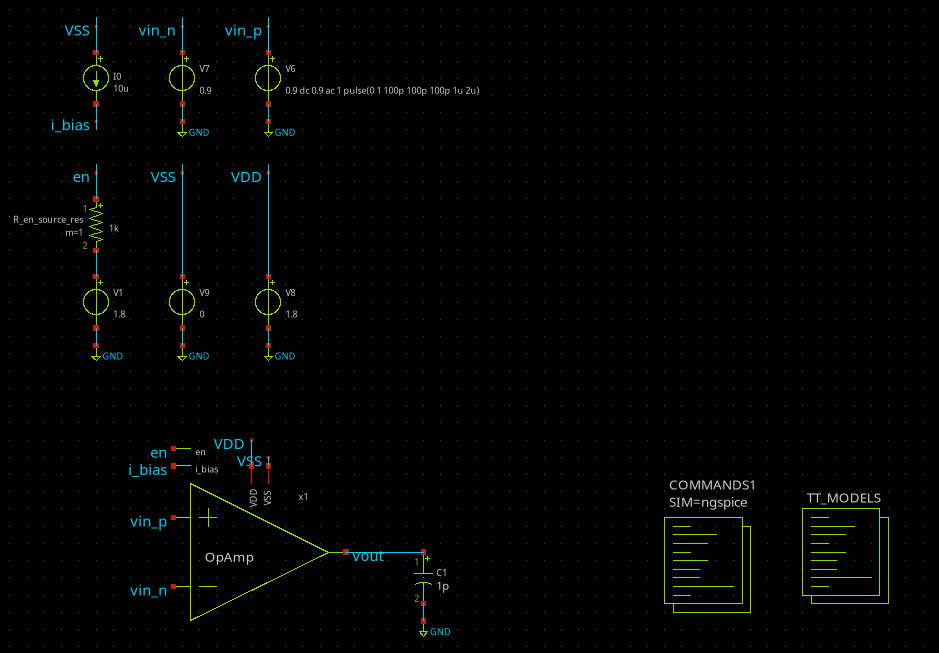

**Schematic of opamp:**
Transistors M9 and M10 form an inverter for the enable tie-down/up.
Transistors M8 and M11 are the tie-down and tie-up transistors for the current mirror and active load.
Transistor M7 breaks the biasing of the current mirror gate in the disabled state.

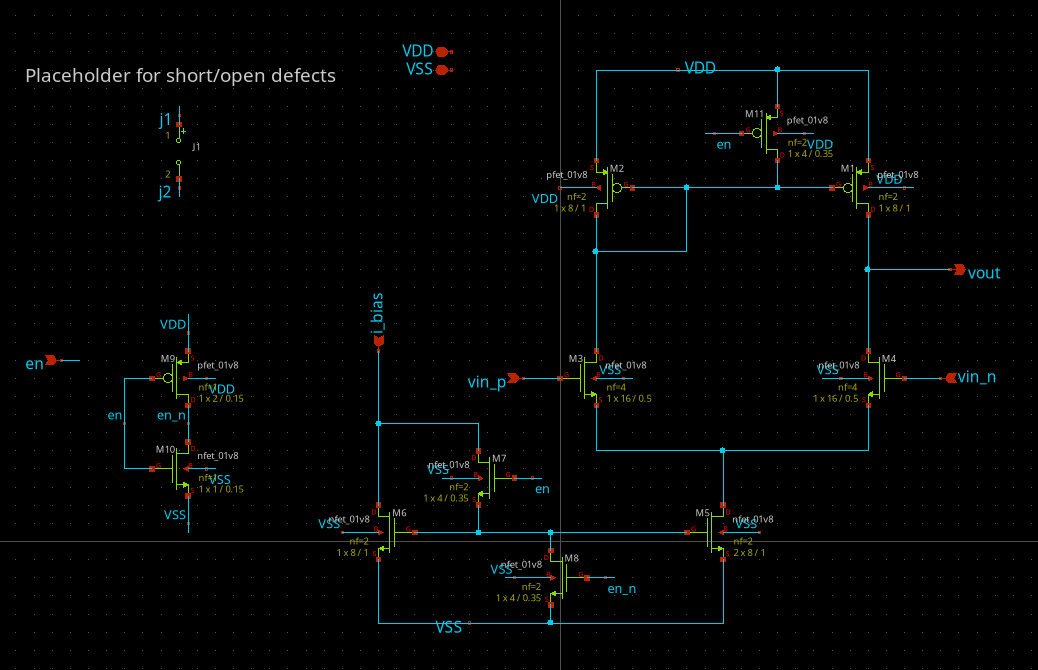

In [19]:
# Download example SPICE netlist from github
spice_netlist_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/netlist/test_analog.spice"
spice_netlist_filename = "test_netlist"
!wget {spice_netlist_url} -O {spice_netlist_filename}.spice
!mkdir generated_netlists

--2024-12-05 01:58:26--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/netlist/test_analog.spice
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5441 (5.3K) [text/plain]
Saving to: ‘test_netlist.spice’

test_netlist.spice  100%[===================>]   5.31K  --.-KB/s    in 0s      

2024-12-05 01:58:26 (43.1 MB/s) - ‘test_netlist.spice’ saved [5441/5441]



In [20]:
# Open SPICE netlist
with open("{}.spice".format(spice_netlist_filename), "r") as netlist_file:
  netlist_contents = netlist_file.read()

  # Print file in terminal
  print(netlist_contents)

** sch_path: /home/timothyjabez/Documents/Open_Source_Circuit_Design/open-source-chip-design-v1/ISSCC_2025_V1/xschem/Benchmark_Circuits/test_analog/test_analog.sch
**.subckt test_analog
V6 vin_p GND 0.9 dc 0.9 ac 1 pulse(0 1 100p 100p 100p 1u 2u)
V7 vin_n GND 0.9
V8 VDD GND 1.8
V9 VSS GND 0
I0 VSS i_bias 10u
V1 net1 GND 1.8
C1 vout GND 1p m=1
x1 VDD vout vin_p vin_n VSS i_bias en OpAmp
R_en_source_res en net1 1k m=1
**** begin user architecture code
.lib /usr/local/share/pdk/sky130B/libs.tech/combined/sky130.lib.spice tt
**** end user architecture code
**.ends

* expanding   symbol:  Benchmark_Circuits/OpAmp/OpAmp.sym # of pins=7
** sym_path: /home/timothyjabez/Documents/Open_Source_Circuit_Design/open-source-chip-design-v1/ISSCC_2025_V1/xschem/Benchmark_Circuits/OpAmp/OpAmp.sym
** sch_path: /home/timothyjabez/Documents/Open_Source_Circuit_Design/open-source-chip-design-v1/ISSCC_2025_V1/xschem/Benchmark_Circuits/OpAmp/OpAmp.sch
.subckt OpAmp VDD vout vin_p vin_n VSS i_bias en
*.ipin vi

## Defect injection into SPICE netlists

In this section, the OpAmp testbench netlist is parsed and defects are injected into the netlists for all devices. It is assumed that that a single defect occurs in each circuit as per Section 3.2 of the IEEE P2427 Draft Standard.

The structure of FET devices is defined as follows:
```
Fet structure (both n and p):
<inst_name> <drain> <gate> <source> <bulk> <cell_name>

Example:
XM1 vout Active_load_g VDD VDD sky130_fd_pr__pfet_01v8 ...
```

``get_fet_devices`` is created to parse the names and terminals of devices and return a list of devices.

In [21]:
def get_fet_devices(netlist_contents):

  # Regular expression to extract FET devices (lines starting with XM)
  regex = r'(?P<inst_name>\w+\d+)\s(?P<drain>\w+)\s(?P<gate>\w+)\s(?P<source>\w+)\s(?P<bulk>\w+)\s(?P<cell_name>sky130_fd_pr__[np]fet_01v8)'
  fet_devices = re.findall(regex, netlist_contents)

  return fet_devices

# Dictionary for mapping transistor terminals to indices
defect_terminal_dict = {
  "Drain": 1,
  "Gate": 2,
  "Source": 3,
  "Bulk": 4,
}

``modify_nelist_open_defect``, ``modify_nelist_short_defect`` and ``modify_netlist_parameter_defect`` are used to inject open, short and parameter defects into a provided netlist.

In [22]:
def modify_nelist_open_defect(netlist, fet_device_terminals, defect_device, defect_terminal_name):

  # Get terminal number
  defect_terminal_num = defect_terminal_dict[defect_terminal_name]
  defect_terminal_netname = fet_device_terminals[defect_terminal_num]

  # Create 3 additional nets to replace original connected to device terminal
  defect_terminal_netname_replaced_1 = "{}1".format(defect_terminal_netname)
  defect_terminal_netname_replaced_2 = "{}2".format(defect_terminal_netname)
  defect_terminal_netname_replaced_3 = "{}3".format(defect_terminal_netname)

  fet_device_terminals_copy = fet_device_terminals.copy()
  # String of original device terminals
  original_device_terminals = " ".join(fet_device_terminals_copy)
  fet_device_terminals_copy[defect_terminal_num] = defect_terminal_netname_replaced_1
  # String of modified device terminals
  modified_device_terminals = " ".join(fet_device_terminals_copy)

  print("Open defect at", defect_terminal_name, fet_device_terminals_copy)

  # Replace device terminals
  modified_netlist = re.sub(original_device_terminals, modified_device_terminals, netlist)
  # Replace remaining occurances of net
  modified_netlist = re.sub(r"\b{}\b".format(defect_terminal_netname), defect_terminal_netname_replaced_2, modified_netlist)

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"

  if (defect_terminal_name == "Drain"):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_drain_open {} {} 1G m=1"
      .format(defect_terminal_netname_replaced_1, defect_terminal_netname_replaced_2),
                              modified_netlist, count=1)
  elif (defect_terminal_name == "Source"):
    # Model open defect by adding a resistor
    modified_netlist= re.sub(placeholder_jumper, "R_source_open {} {} 1G m=1"
      .format(defect_terminal_netname_replaced_1,
              defect_terminal_netname_replaced_2),
                              modified_netlist, count=1)
  elif (defect_terminal_name == "Gate"):
    # Model open defect for gate by adding a resistor network
    modified_netlist = re.sub(placeholder_jumper, "R_gate1_drain_open {gate1} {drain} 0.5T m=1 \n \
      R_gate1_source_open {gate1} {source} 0.5T m=1 \n \
      R_gate1_gate_open {gate1} {gate} 1T m=1 \n \
      R_gate1_gate2_open {gate1} {gate2} 100T m=1"
      .format(gate=defect_terminal_netname_replaced_1,
              gate2=defect_terminal_netname_replaced_2,
              gate1=defect_terminal_netname_replaced_3,
              drain=fet_device_terminals_copy[1],
              source=fet_device_terminals_copy[3]),
                              modified_netlist, count=1)

  return modified_netlist

def modify_nelist_short_defect(netlist, fet_device_terminals, defect_device, defect_terminal_name_1, defect_terminal_name_2):

  print("Short defect at", defect_terminal_name_1, "-", defect_terminal_name_2, fet_device_terminals)

  # Get terminal number
  defect_terminal_num_1 = defect_terminal_dict[defect_terminal_name_1]
  defect_terminal_netname_1 = fet_device_terminals[defect_terminal_num_1]
  defect_terminal_num_2 = defect_terminal_dict[defect_terminal_name_2]
  defect_terminal_netname_2 = fet_device_terminals[defect_terminal_num_2]

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"

  if ((defect_terminal_name_1 == "Drain" and defect_terminal_name_2 == "Source") \
      or (defect_terminal_name_1 == "Source" and defect_terminal_name_2 == "Drain")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_drain_source_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  elif ((defect_terminal_name_1 == "Gate" and defect_terminal_name_2 == "Drain") \
        or (defect_terminal_name_1 == "Drain" and defect_terminal_name_2 == "Source")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_gate_drain_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  elif ((defect_terminal_name_1 == "Gate" and defect_terminal_name_2 == "Source") \
        or (defect_terminal_name_1 == "Source" and defect_terminal_name_2 == "Gate")):
    # Model open defect by adding a resistor
    modified_netlist = re.sub(placeholder_jumper, "R_gate_source_short {} {} 1 m=1"
      .format(defect_terminal_netname_1, defect_terminal_netname_2),
                              netlist, count=1)

  return modified_netlist

def modify_nelist_parameter_defect(netlist, fet_device_terminals, defect_device, speed):

  print(speed, "parameter defect at", fet_device_terminals[0], fet_device_terminals)

  placeholder_jumper = "[\*] J1 [?]1 j1 [?]1 j2"
  cellname_terminal_num = 5

  fet_device_terminals_copy = fet_device_terminals.copy()
  # String of original device terminals
  original_device_terminals = " ".join(fet_device_terminals_copy)

  if (speed == "fast"):
    if (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__pfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__pfet_01v8_defect_fast"
    elif (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__nfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__nfet_01v8_defect_fast"
  elif (speed == "slow"):
    if (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__pfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__pfet_01v8_defect_slow"
    elif (fet_device_terminals_copy[cellname_terminal_num] == "sky130_fd_pr__nfet_01v8"):
      fet_device_terminals_copy[cellname_terminal_num] = "sky130_fd_pr__nfet_01v8_defect_slow"

  # String of modified device terminals
  modified_device_terminals = " ".join(fet_device_terminals_copy)

  # Replace device terminals
  modified_netlist = re.sub(original_device_terminals, modified_device_terminals, netlist)

  # Remove placeholder jumper device
  modified_netlist = re.sub(placeholder_jumper, "", modified_netlist)

  return modified_netlist

``generate_spice_netlists`` invokes ``modify_nelist_open_defect`` or ``modify_nelist_short_defect`` to generate a modified netlist which is then saved to a new file.

In [23]:
def generate_spice_netlists(netlist, defect_type, fet_device_terminals, defect_device_num, defect_terminal_name_1, defect_terminal_name_2):

  if (defect_type == "Open"):
    modified_netlist_contents = modify_nelist_open_defect(
        netlist, fet_device_terminals, defect_device_num, defect_terminal_name_1)

  elif (defect_type == "Short"):
    modified_netlist_contents = modify_nelist_short_defect(
        netlist, fet_device_terminals, defect_device_num, defect_terminal_name_1,
        defect_terminal_name_2)

  elif (defect_type == "Parameter_Fast"):
    modified_netlist_contents = modify_nelist_parameter_defect(
        netlist, fet_device_terminals, defect_device_num, "fast")

  elif (defect_type == "Parameter_Slow"):
    modified_netlist_contents = modify_nelist_parameter_defect(
        netlist, fet_device_terminals, defect_device_num, "slow")

  modified_netlist_contents = re.sub("opamp_specs.txt", "opamp_specs_{}_{}_{}_{}_{}.txt"
      .format(defect_device_num,fet_device_terminals[0],
              defect_type,defect_terminal_name_1,defect_terminal_name_2),
                              modified_netlist_contents)

  # Open a file for writing modified netlist
  with open("./generated_netlists/{}_{}_{}_{}_{}_{}.spice"
    .format(spice_netlist_filename,defect_device_num,fet_device_terminals[0],
            defect_type,defect_terminal_name_1,defect_terminal_name_2), "w") as file:
      file.write(modified_netlist_contents)


Modified netlists are generated to model every type of defect for every transistor in the netlist.

In [24]:
# Extract all fet devices from netlist
fet_devices = get_fet_devices(netlist_contents)

# Create netlists with defects injected
for defect_device_num in range(0,len(fet_devices)-1):
  fet_device_terminals = list(fet_devices[defect_device_num])
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Drain", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Source", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Open", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Drain", defect_terminal_name_2="Source")
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2="Drain")
  generate_spice_netlists(netlist_contents, "Short", fet_device_terminals, defect_device_num, defect_terminal_name_1="Gate", defect_terminal_name_2="Source")
  generate_spice_netlists(netlist_contents, "Parameter_Fast", fet_device_terminals, defect_device_num, defect_terminal_name_1=None, defect_terminal_name_2=None)
  generate_spice_netlists(netlist_contents, "Parameter_Slow", fet_device_terminals, defect_device_num, defect_terminal_name_1=None, defect_terminal_name_2=None)

Open defect at Drain ['XM1', 'vout1', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Open defect at Source ['XM1', 'vout', 'net2', 'VDD1', 'VDD', 'sky130_fd_pr__pfet_01v8']
Open defect at Gate ['XM1', 'vout', 'net21', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Short defect at Drain - Source ['XM1', 'vout', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Short defect at Gate - Drain ['XM1', 'vout', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Short defect at Gate - Source ['XM1', 'vout', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
fast parameter defect at XM1 ['XM1', 'vout', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
slow parameter defect at XM1 ['XM1', 'vout', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Open defect at Drain ['XM2', 'net21', 'net2', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Open defect at Source ['XM2', 'net2', 'net2', 'VDD1', 'VDD', 'sky130_fd_pr__pfet_01v8']
Open defect at Gate ['XM2', 'net2', 'net21', 'VDD', 'VDD', 'sky130_fd_pr__pfet_01v8']
Short

The following cell is optional for downloading the generated_netlists.

In [25]:
# # Download generated netlists
# !zip -r generated_netlists.zip /content/generated_netlists

# from google.colab import files
# files.download("/content/generated_netlists.zip")

## Batch running simulations with NGSpice

In this section, the modified netlists are run using the NGSpice simulator in batch mode.

In [26]:
# Code to replace string in all spice files
# This was created to replace .lib path for netlists created locally
def replace_string_in_spice_files(folder_path, original_pdk_path, final_pdk_path):

  # Iterate over files in directory
  for spice_file_name in os.listdir(folder_path):
    if spice_file_name.endswith(".spice"):

      # Read files
      with open(os.path.join(folder_path, spice_file_name), 'r') as spice_file:
        netlist = spice_file.read()

      modified_netlist = re.sub(original_pdk_path, final_pdk_path, netlist)

      # Write modified files
      with open(os.path.join(folder_path, spice_file_name), 'w') as spice_file:
        spice_file.write(modified_netlist)

replace_string_in_spice_files("/content/generated_netlists", "/usr/local/share/pdk/sky130B/", "/content/conda-env/share/pdk/sky130A/") #"/foss/pdks/sky130A/"

In [27]:
# Download batch run shell file from github
ngspice_batchrun_file_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/ngspice_batchrun.sh"
ngspice_batchrun_file = "ngspice_batchrun.sh"
!wget {ngspice_batchrun_file_url} -O {ngspice_batchrun_file}

specs_dir = "./specs/"
!mkdir {specs_dir}

--2024-12-05 01:58:26--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/ngspice_batchrun.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘ngspice_batchrun.sh’

ngspice_batchrun.sh 100%[===================>]      71  --.-KB/s    in 0s      

2024-12-05 01:58:26 (5.20 MB/s) - ‘ngspice_batchrun.sh’ saved [71/71]



In [28]:
!bash /content/ngspice_batchrun.sh

Streaming output truncated to the last 5000 lines.
Checking parameters for BSIM 4.5 model x1.xm8:nshort_model.22

Checking parameters for BSIM 4.5 model x1.xm7:nshort_model.22
Note: v6: dc value used for op instead of transient time=0 value.
 Reference value :  0.00000e+00
No. of Data Rows : 1
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Checking parameters for BSIM 4.5 model x1.xm8:nshort_model.22

Checking parameters for BSIM 4.5 model x1.xm7:nshort_model.22
Note: v6: dc value used for op instead of transient time=0 value.

Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vin_p                                        0
vin_n                                      0.9
vdd                                        1.8
vss                                          0
i_bias                                0.667603
net1                                       1.8
vout                    

## Automatic testing of specs files
In this section, the testbench performance parameters for all injected defects are compared with the acceptable ranges in ``specs_range.txt``.

In [29]:
# Download specs range file from github
specs_range_file_url = f"https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/opamp_specs_range.txt"
specs_range_file = "specs_range.txt"
!wget {specs_range_file_url} -O {specs_range_file}

--2024-12-05 02:02:07--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Jupyter_Notebooks/opamp_specs_range.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226 [text/plain]
Saving to: ‘specs_range.txt’

specs_range.txt     100%[===================>]     226  --.-KB/s    in 0s      

2024-12-05 02:02:07 (13.0 MB/s) - ‘specs_range.txt’ saved [226/226]



The specification files consists of minimum and maximum values for the performance parameters in separate lines.

In [30]:
# Open specs_range.txt file
with open(specs_range_file, "r") as specs_range_file_content:
  # Print file in terminal
  print(specs_range_file_content.read())

slew_rate     = 1e+07	:  5e+07
power_average = 5e-06	:  10e-06
aol_dc_db     = 3e+01	: 4.5e+01
bw3db         = 3e+05   : 5e+05
ugbw          = 2e+07   : 3.5e+07
gain_margin   = -7e+01 	: -5e+01
phase_margin  = 7e+01  	: 9e+01



``register_ranges`` parses a file with performance parameter ranges and creates a dictionary containting the ranges.

``test_specs_file`` uses the performance parameter ranges to test the simulated performance parameters for all defects and returns a dictionary with results.

In [31]:
def register_ranges(path_file_range):

  range_dict = {}

  # Opens specs_range file and places max and min into a dictionary
  with open(path_file_range, "r") as file:
    for line in file:
      # Regex to find numbers after '='
      match_number_min = re.search(r"=\s*(-?\d+(\.\d+)?([eE][+-]?\d+)?)", line)
      match_number_max = re.search(r":\s*(-?\d+(\.\d+)?([eE][+-]?\d+)?)", line)

      match_spec_property = re.search(r"([^\s=]+)\s*=", line)

      if match_spec_property:
          spec_property = match_spec_property.group(1)

      if match_number_max:
          spec_value_max_scientific = match_number_max.group(1)  # Extract the matched number (its common name to hold reg expressions)
          spec_value_max = float(spec_value_max_scientific)

      if match_number_min:
          spec_value_min_scientific = match_number_min.group(1)  # Extract the matched number (its common name to hold reg expressions)
          spec_value_min = float(spec_value_min_scientific)

      range_dict[f"{spec_property}"] = [spec_value_min, spec_value_max]

    return range_dict

In [32]:
def test_specs_file(path_file, range_dict):

  results_dict = {}
  results_dict["path_file"] = path_file

  overall_result = 1

  with open(path_file, "r") as file:
    for line in file:

      # Regex to find numbers after '='
      match_number = re.search(r"=\s*(-?\d\.?\d+[Ee][+\-]\d\d?)", line)
      match_spec_property = re.search(r"([^\s=]+)\s*=", line)

      if match_spec_property:
        spec_property = match_spec_property.group(1)

      if match_number:
        spec_value_scientific = match_number.group(1)  # Extract the matched number (its common name to hold reg expressions)
        spec_value = float(spec_value_scientific)

      if range_dict[spec_property][0] <= spec_value <= range_dict[spec_property][1]:
        results_dict[spec_property] = 1

      else:
        results_dict[spec_property] = 0
        overall_result = 0

  results_dict["overall_result"] = overall_result

  return results_dict

The next cell runs the automated tests on all generated performance parameter files.

In [33]:
range_dict = register_ranges(path_file_range=specs_range_file)
results_dict_list = []

# Iterate over performance parameter files in directory
for filename in os.listdir(specs_dir):
    results_dict = test_specs_file(os.path.join(specs_dir, filename), range_dict)
    results_dict_list.append(results_dict)

results_df = pd.DataFrame(results_dict_list)
results_df.to_csv("results_summary.csv")

                                            path_file  slew_rate  \
0     ./specs/opamp_specs_4_XM5_Short_Gate_Source.txt          0   
1        ./specs/opamp_specs_5_XM6_Open_Gate_None.txt          0   
2   ./specs/opamp_specs_2_XM3_Parameter_Fast_None_...          1   
3      ./specs/opamp_specs_9_XM8_Open_Source_None.txt          1   
4   ./specs/opamp_specs_4_XM5_Parameter_Fast_None_...          1   
..                                                ...        ...   
75       ./specs/opamp_specs_1_XM2_Open_Gate_None.txt          0   
76  ./specs/opamp_specs_3_XM4_Parameter_Slow_None_...          1   
77  ./specs/opamp_specs_8_XM7_Parameter_Fast_None_...          1   
78    ./specs/opamp_specs_5_XM6_Short_Gate_Source.txt          0   
79   ./specs/opamp_specs_4_XM5_Short_Drain_Source.txt          0   

    power_average  aol_dc_db  bw3db  ugbw  gain_margin  phase_margin  \
0               0          0      0     0            0             0   
1               0          0      0    

In [34]:
results_df

,path_file,slew_rate,power_average,aol_dc_db,bw3db,ugbw,gain_margin,phase_margin,overall_result
0,./specs/opamp_specs_4_XM5_Short_Gate_Source.txt,0,0,0,0,0,0,0,0
1,./specs/opamp_specs_5_XM6_Open_Gate_None.txt,0,0,0,0,0,0,0,0
2,./specs/opamp_specs_2_XM3_Parameter_Fast_None_...,1,1,0,0,0,0,0,0
3,./specs/opamp_specs_9_XM8_Open_Source_None.txt,1,1,1,1,1,1,1,1
4,./specs/opamp_specs_4_XM5_Parameter_Fast_None_...,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
75,./specs/opamp_specs_1_XM2_Open_Gate_None.txt,0,0,0,0,0,0,0,0
76,./specs/opamp_specs_3_XM4_Parameter_Slow_None_...,1,0,0,0,0,1,0,0
77,./specs/opamp_specs_8_XM7_Parameter_Fast_None_...,1,1,1,1,1,1,1,1
78,./specs/opamp_specs_5_XM6_Short_Gate_Source.txt,0,0,0,0,0,0,0,0


As can be seen from the results summary, there are some tests that are redundant since there are multiple tests that can detect the same defects.

## Data Visualisation

A script with tcl commands is generated by filtering the test results that passed. It highlights the instance involved in the test and print a png image. This is to help visualise the defects that cannot be detected.

In [ ]:
filtered_data = results_df[results_df['overall_result'] == 1]

# Generate TCL commands with unique filenames
with open('xschem_commands.tcl', 'w') as file:
    # file.write(f'xschem OpAmp.sch\n')
    for index, row in filtered_data.iterrows():
        # Extract the instance name from path_file (e.g., "XM10")
        path_parts = row['path_file'].split('_')
        instance_name = path_parts[3][1:]  # e.g., "M10"
        additional_info = '_'.join(path_parts[4:]).replace('.txt', '')  # e.g., "Open_Drain_None"

        # Create a unique filename using the index
        unique_filename = f"{instance_name.lower()}_{additional_info.lower()}_{index}.png"

        # Write TCL commands
        file.write(f'xschem hilight_instname {instance_name}\n')
        file.write(f'xschem print png {unique_filename} 0 0 -800 -650 650 200\n') # export the area where the circuit is
        file.write(f'xschem unhilight_all\n')

print("TCL commands have been written to 'xschem_commands.tcl'")

TCL commands have been written to 'xschem_commands.tcl'


In [ ]:
# Import op amp schematic file from github
!wget https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/xschem/Benchmark_Circuits/OpAmp/OpAmp.sch -O OpAmp_Schematic.sch


--2024-12-05 00:32:53--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/ISSCC_2025_V1/xschem/Benchmark_Circuits/OpAmp/OpAmp.sch
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7835 (7.7K) [text/plain]
Saving to: ‘OpAmp_Schematic.sch’

OpAmp_Schematic.sch 100%[===================>]   7.65K  --.-KB/s    in 0s      

2024-12-05 00:32:53 (61.7 MB/s) - ‘OpAmp_Schematic.sch’ saved [7835/7835]



In [ ]:
# Code to replace string in all spice files
# This was created to replace .lib path for netlists created locally
def replace_string_in_sch_files(folder_path, original_pdk_path, final_pdk_path):

  # Iterate over files in directory
  for spice_file_name in os.listdir(folder_path):
    if spice_file_name.endswith(".sch"):

      # Read files
      with open(os.path.join(folder_path, spice_file_name), 'r') as spice_file:
        netlist = spice_file.read()

      modified_netlist = re.sub(original_pdk_path, final_pdk_path, netlist)

      # Write modified files
      with open(os.path.join(folder_path, spice_file_name), 'w') as spice_file:
        spice_file.write(modified_netlist)

replace_string_in_sch_files("/content", "/usr/local/share/pdk/sky130A/", "/content/conda-env/share/pdk/sky130A/") #"/foss/pdks/sky130A/"

In [ ]:
# Issue trying to generate png images in Jupyter Notebook, tcl commands not reacting, could be due to absence of gui
# !xschem OpAmp_Schematic.sch --script xschem_commands.tcl -l test.log -b -q

In [ ]:
# Import images that are generated in our local environment using the script generated into the images folder
!mkdir images
!wget https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Automated_Image_Export/screenshots_2.tar.gz -O images/defect_images.tar.gz

mkdir: cannot create directory ‘images’: File exists
--2024-12-05 00:32:53--  https://github.com/TimothyJNewman/open-source-chip-design-v1/raw/refs/heads/main/Automated_Image_Export/screenshots_2.tar.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Automated_Image_Export/screenshots_2.tar.gz [following]
--2024-12-05 00:32:53--  https://raw.githubusercontent.com/TimothyJNewman/open-source-chip-design-v1/refs/heads/main/Automated_Image_Export/screenshots_2.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 482246 (471K) [application/o

In [ ]:
!rm -rf images/*.png
!cd images && tar -xzvf /content/images/defect_images.tar.gz

m10_open_drain_none_0.png
tar: m10_open_drain_none_0.png: time stamp 2024-12-05 16:00:17 is 55642.780466212 s in the future
m10_open_source_none_21.png
tar: m10_open_source_none_21.png: time stamp 2024-12-05 16:00:18 is 55643.77980817 s in the future
m10_short_drain_source_49.png
tar: m10_short_drain_source_49.png: time stamp 2024-12-05 16:00:18 is 55643.779157387 s in the future
m2_short_gate_drain_17.png
tar: m2_short_gate_drain_17.png: time stamp 2024-12-05 16:00:18 is 55643.778729845 s in the future
m6_short_gate_drain_58.png
tar: m6_short_gate_drain_58.png: time stamp 2024-12-05 16:00:19 is 55644.777977543 s in the future
m7_open_source_none_24.png
tar: m7_open_source_none_24.png: time stamp 2024-12-05 16:00:18 is 55643.777390852 s in the future
m7_short_drain_source_5.png
tar: m7_short_drain_source_5.png: time stamp 2024-12-05 16:00:17 is 55642.7770042 s in the future
m8_open_drain_none_11.png
tar: m8_open_drain_none_11.png: time stamp 2024-12-05 16:00:18 is 55643.776496154 s in 

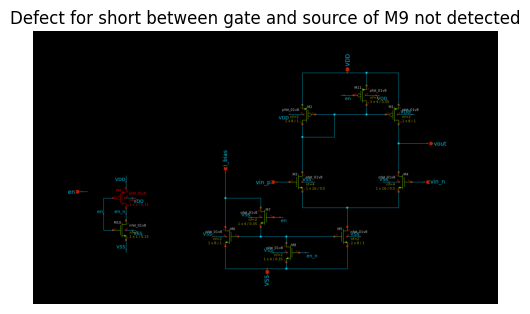

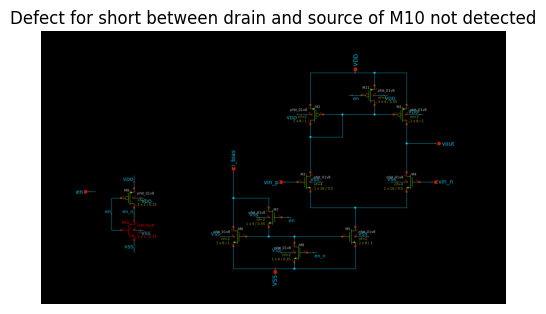

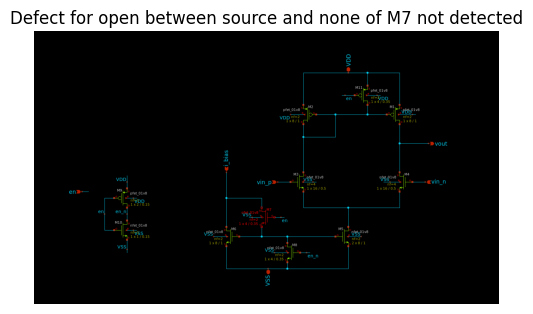

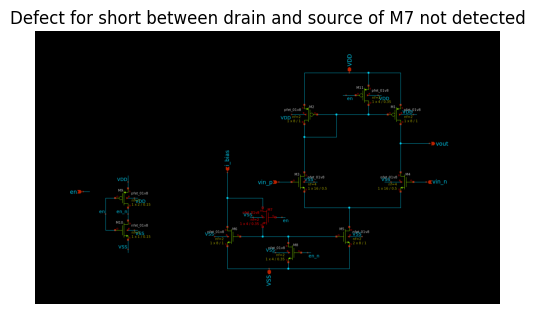

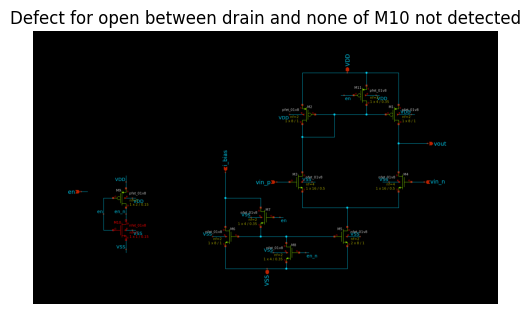

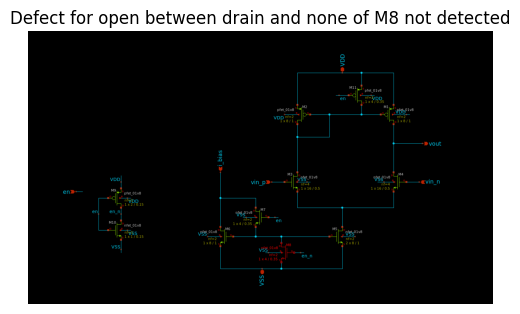

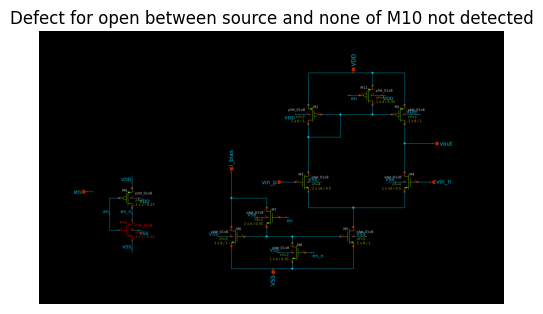

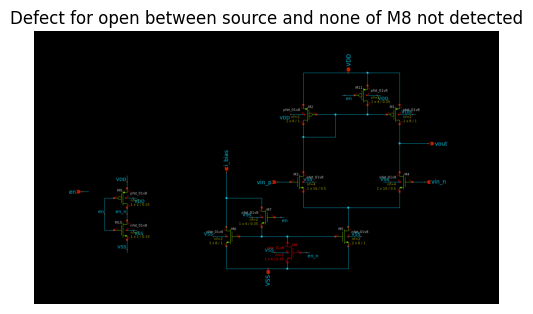

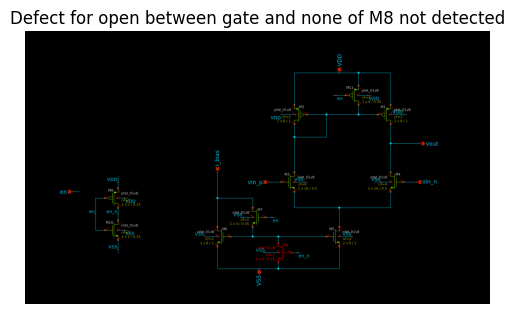

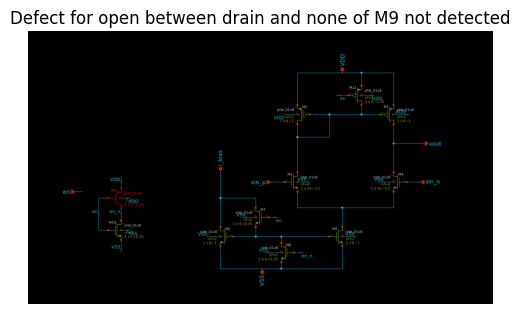

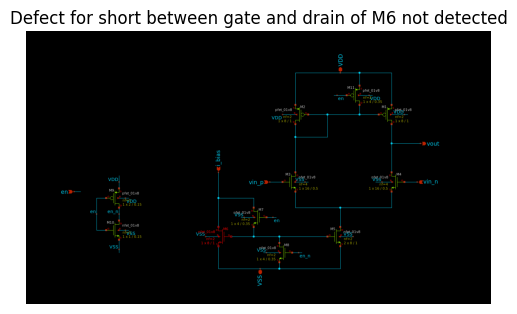

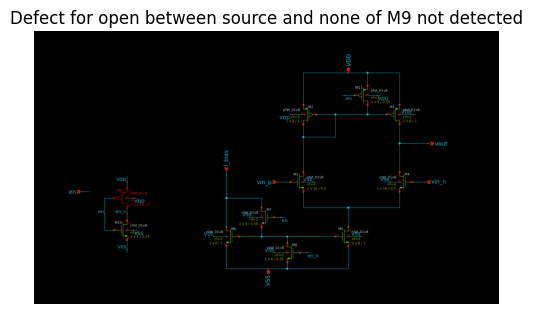

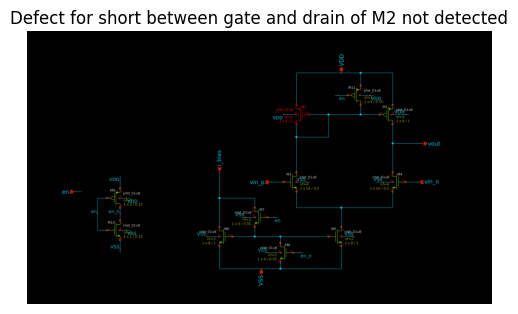

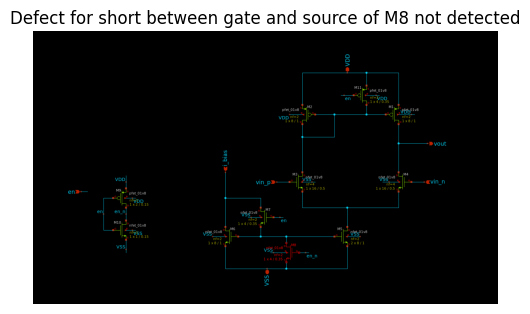

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_directory = "/content/images"

def generate_label(filename):
    parts = filename.split('_')  # Split the filename by '_'
    instance = parts[0].upper()  # E.g., "M10"
    defect_type_1 = '_'.join(parts[1:2])
    defect_type_2 = '_'.join(parts[2:3])
    defect_type_3 = '_'.join(parts[3:4])
    return f"Defect for {defect_type_1} between {defect_type_2} and {defect_type_3} of {instance} not detected"

for file in os.listdir(image_directory):
    if file.endswith(".png"):  # Check if the file is a PNG image
        filepath = os.path.join(image_directory, file)

        # Open the image
        img = Image.open(filepath)

        # Generate the label
        label = generate_label(file)

        # Display the image with the label
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(label, fontsize=12, wrap=True)
        plt.show()

In [ ]:
total_tests = len(results_df)
defect_coverage_percentage = (len(results_df[results_df['overall_result'] == 0]) / total_tests) * 100

print("Defect coverage percentage = ", defect_coverage_percentage, "%")

Defect coverage percentage =  72.5 %


## Discussion

It can be seen that many of the defects that are not detected by the tests are for the digital and enable switches. To detect some of these cases, it might be advisable to add more tests such as average off-state power consumption which will catch cases where the enable devices are bypassed.

In certain cases such for device M2, there is an intentional short between the drain and gate to use the device in a current mirror. As such, a drain-gate short defect would not affect performance.